## Analysis
- Vader Analysis might not be giving accurate specific analysis since some of the neutral tweets like job report stats had a negative value assigned to them. moreover, 100 tweets might be a little less to guage the news outlet's sentiment. more data has to be analyzed to arrive at a better polarity analysis


- Out of all the 5 outlets, NYT appears to be consistenly more neutral and more in line with the current happenings (again this will be specific to the time of the day and happenings). The other outlets are overtly positive or negative depending on how they want to influence their followers and how they want to protray the current happenings.


- when new outlets other than NYT tweeted neutral sentiments tweets, events directly related to those tweets were insignificant / or were deemed to be not new-worthy and so the outlets didn't seem to put any positive/negative spin to them


In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
from matplotlib import style
style.use('seaborn')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
def retrieve_tweet(target_user):

    oldest_tweet = None
    counter = 1

    public_tweets = api.user_timeline(target_user, max_id = oldest_tweet,count=100)

    for tweet in public_tweets:

        # Run Vader Analysis on each tweet
        results = analyzer.polarity_scores(tweet["text"])

        # Get Tweet ID, subtract 1, and assign to oldest_tweet
        oldest_tweet = tweet['id'] - 1

        # Add sentiments for each tweet into a list
        sentiments.append({"User": tweet["user"]["name"],
                           "Date": tweet["created_at"],
                           "Tweet": tweet["text"],
                           "Compound": results["compound"],
                           "Positive": results["pos"],
                           "Negative": results["neu"],
                           "Neutral": results["neg"],
                           "Tweets Ago": counter})

        # Add to counter 
        counter += 1

In [3]:
# Target Search Term
target_terms = ("@CNN", "@BBC", "@CBSNews","@FoxNews", "@nytimes")
sentiments = []
now = datetime.now()
now = now.strftime("%m/%d/%y")

for target_user in target_terms:
    retrieve_tweet(target_user)
    time.sleep(2)

In [4]:
# Convert sentiments to DataFrame
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd.to_csv("media_sentiments.csv", encoding='utf-8', index=False)

In [5]:
sentimentsbyUser_df= sentiments_pd.groupby("User",as_index = None)

## Sentiment Analysis

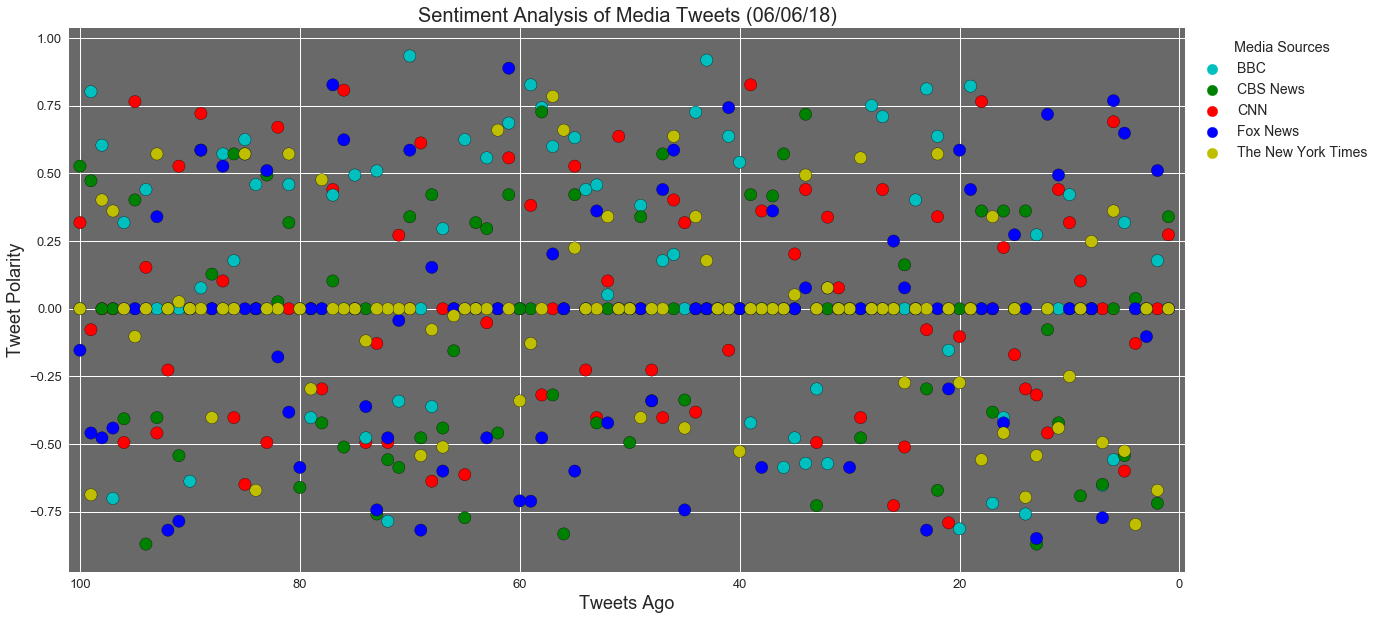

In [6]:
col = np.where(sentiments_pd["User"]=="CNN",'r',np.where(sentiments_pd["User"]=="BBC",'c',np.where(sentiments_pd["User"]=="CBS News",'g',np.where(sentiments_pd["User"]=="Fox News",'b','y'))))
plt.rcParams['axes.facecolor']='dimgrey'
sentiments_pd.plot.scatter('Tweets Ago', 'Compound', c=col,figsize=(20,10),s=150,edgecolors="black")
plt.title(f"Sentiment Analysis of Media Tweets ({now})",fontsize=20)
plt.xlim([sentiments_pd["Tweets Ago"].max()+1,sentiments_pd["Tweets Ago"].min()-1.5])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Tweet Polarity",fontsize=18)
plt.xlabel("Tweets Ago", fontsize=18)
color = ['c','g','r','b','y']
colorcount = 0
for user in sentimentsbyUser_df.mean()["User"]:
    plt.scatter([], [], c=color[colorcount],label=user)
    colorcount+=1
lgnd = plt.legend(loc = "upper left", bbox_to_anchor=(1,1), markerscale=1.5,title='Media Sources',fontsize=14)
plt.setp(lgnd.get_title(),fontsize='x-large')
plt.savefig("SentimentAnalysis.png",bbox_inches="tight")
plt.show()

In [7]:
overallSentiments_df = pd.DataFrame({"NewsOrg":["BBC","CBS","CNN","Fox","NYT"],
                          "Polarity":[np.mean(sentiments_pd.loc[sentiments_pd["User"]=="BBC","Compound"]),
                                      np.mean(sentiments_pd.loc[sentiments_pd["User"]=="CBS News","Compound"]),
                                      np.mean(sentiments_pd.loc[sentiments_pd["User"]=="CNN","Compound"]),
                                      np.mean(sentiments_pd.loc[sentiments_pd["User"]=="Fox News","Compound"]),        
                                      np.mean(sentiments_pd.loc[sentiments_pd["User"]=="The New York Times","Compound"])]})

## Overall Polarity

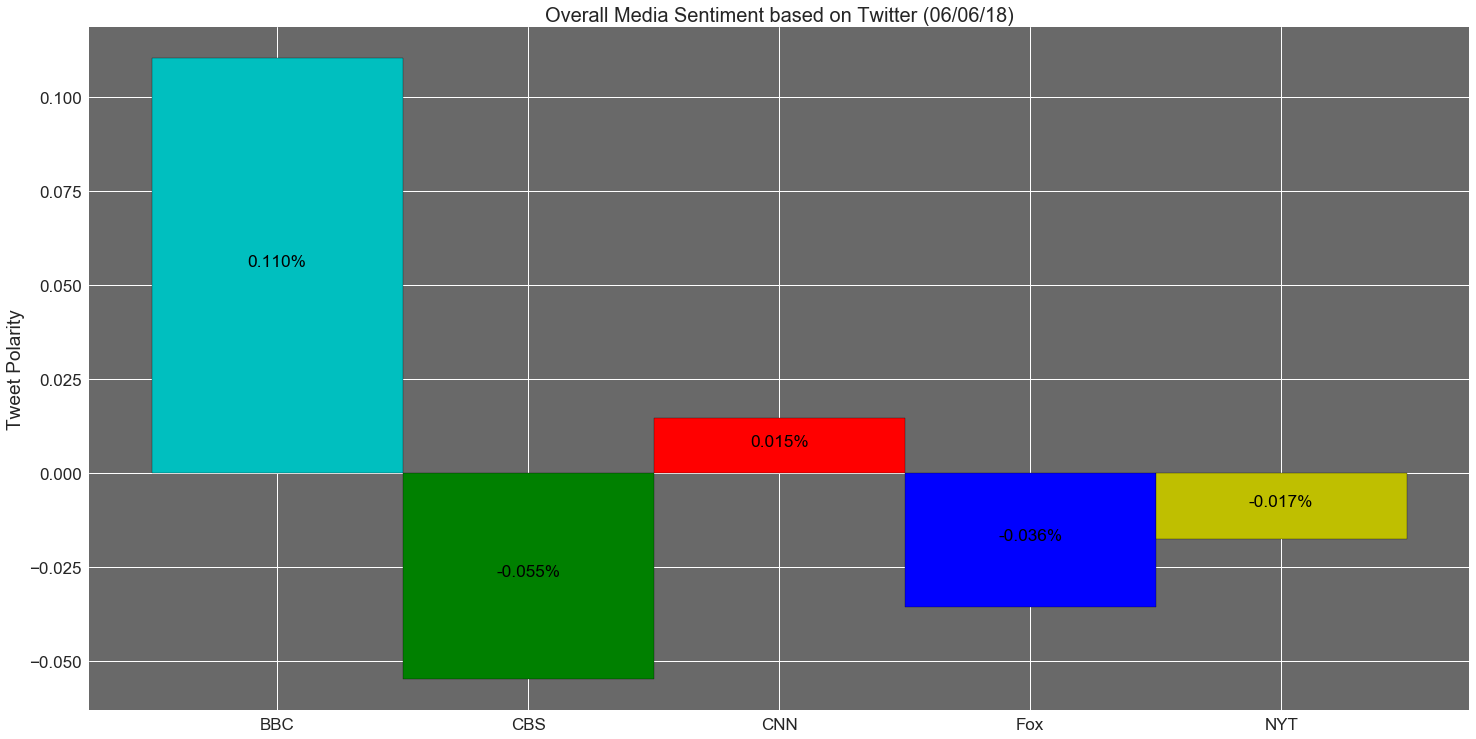

In [8]:
plt.figure(figsize=(20,10))
colors = ['c','g','r','b','y']
rects = plt.bar(overallSentiments_df["NewsOrg"],overallSentiments_df["Polarity"],width=1,edgecolor='black',color=colors)
plt.tight_layout()
plt.ylabel("Tweet Polarity",fontsize=19)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(f"Overall Media Sentiment based on Twitter ({now})",fontsize=20)
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2,height/2,
            '%.3f%%' % (height),
            ha='center', va='baseline',size="xx-large",color="black")
plt.savefig("OverallSentiment.png",bbox_inches="tight")    
plt.show()